## HW4 - Fine Tuning of Neural Networks

### README
In the main() function:
1. Change the paths to your trainfile.txt, valfile.txt, testfile.txt
2. Change the path to your flowers102stuff/102flowers/flowers_data/jpg folder
3. Run jupyter notebook

### Import libraries

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
# from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.cuda.get_device_name(0)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Device:  cuda:0


'GeForce GTX 1650'

### Load Data

In [2]:
# Load text files
def split_txt_file(file):
    file = open(file,"r")
    imgs = []
    labels = []
    for line in file:        
      fields = line.split(" ")      
      img = fields[0]
      label = fields[1]
      imgs.append(img)
      labels.append(label)
    return np.asarray(imgs), np.asarray(labels)



class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, root_dir,transform):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.x = x
        self.y = y.astype(int)
        self.y = torch.from_numpy(self.y)
        self.y = self.y.type(torch.long)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.x[idx])
        image = Image.open(img_name) # (channels, width, height)
        image = self.transform(image)    
        label = self.y[idx]
        sample = {'image': image, 'label': label}        

        return sample['image'], sample['label']

def create_dataloaders(train_txt, val_txt, test_txt, jpg_dir, input_size):
    # Create train, val, test dataloaders
    train_x, train_y = split_txt_file(train_txt)
    val_x, val_y = split_txt_file(val_txt)
    test_x, test_y = split_txt_file(test_txt)
    
    # data transformers
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    
    # Creating train, val, test datasets and dataloaders
    trainset = Dataset(x = train_x,
                       y = train_y,
                       root_dir = jpg_dir,
                       transform=data_transforms['train'])

    trainloader = torch.utils.data.DataLoader(trainset,
                                              batch_size=8,
                                              shuffle=True,
                                              num_workers=0)

    valset = Dataset(x = val_x,
                    y = val_y,
                    root_dir = jpg_dir,
                    transform=data_transforms['val'])

    valloader = torch.utils.data.DataLoader(valset,
                                            batch_size=8,
                                            shuffle=False,
                                            num_workers=0)

    testset = Dataset(x = test_x,
                      y = test_y,
                      root_dir = jpg_dir,
                      transform=data_transforms['test'])

    testloader = torch.utils.data.DataLoader(testset,
                                              batch_size=8,
                                              shuffle=False,
                                              num_workers=0)

    dataloaders = {'train':trainloader, 'val':valloader, 'test':testloader}
    
    return dataloaders  

### Model Training and Validation Code

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    # train, val, test acc & loss dictionary
    graph_data = defaultdict(list)    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                # Set model to evaluate mode
                # model.eval() will notify all your layers that you are in eval mode, that way,
                # batchnorm or dropout layers will work in eval mode instead of training mode.
                # torch.no_grad() impacts the autograd engine and deactivate it. It will 
                # reduce memory usage and speed up computations but you won’t be able to 
                # backprop (which you don’t want in an eval script).                
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # check and load best model
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                 # load best model weights
                model.load_state_dict(best_model_wts)
            
            # acc & loss chart   
            if phase == 'train':
                graph_data['train_acc'].append(epoch_acc)
                graph_data['train_loss'].append(epoch_loss)
            
            if phase == 'val':
                graph_data['val_acc'].append(epoch_acc)
                graph_data['val_loss'].append(epoch_loss)
            
            if phase =='test':
                graph_data['test_acc'].append(epoch_acc)
                graph_data['test_loss'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, graph_data

### Set & Print Trainable Layers 

In [4]:
# Set parameters to be trained
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract == True:
        # Clarified with Prof Alex: Set last fc layer and second last fc block as trainable
        trainable_layers = ['layer4.0.conv1.weight',
                            'layer4.0.bn1.weight',
                            'layer4.0.bn1.bias',
                            'layer4.0.conv2.weight',
                            'layer4.0.bn2.weight',
                            'layer4.0.bn2.bias',
                            'layer4.0.downsample.0.weight',
                            'layer4.0.downsample.1.weight',
                            'layer4.0.downsample.1.bias',
                            'layer4.1.conv1.weight',
                            'layer4.1.bn1.weight',
                            'layer4.1.bn1.bias',
                            'layer4.1.conv2.weight',
                            'layer4.1.bn2.weight',
                            'layer4.1.bn2.bias',
                            'fc.weight',
                            'fc.bias'
                           ]
        for name, param in model.named_parameters():
            if name in trainable_layers:
                param.requires_grad = True
            else:
                param.requires_grad = False 

def set_trainable_params(model_ft, feature_extract):
    # Gather the parameters to be optimized/updated in this run. If we are
    # finetuning we will be updating all parameters. However, if we are
    # doing feature extract method, we will only update the parameters
    # that we have just initialized, i.e. the parameters with requires_grad
    # is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract == True:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    return params_to_update

### Initialize and Reshape the Networks

In [5]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

### Plot Graphs

In [6]:
def plot_graphs(num_epochs, graph_data, model):
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    plt.title('Acc vs Epoch [Model {}]'.format(model))
    plt.plot(range(1, num_epochs+1), graph_data['train_acc'], label='train_acc')
    plt.plot(range(1, num_epochs+1), graph_data['val_acc'], label='val_acc')
    plt.plot(range(1, num_epochs+1), graph_data['test_acc'], label='test_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()

    plt.subplot(122)
    plt.title('Loss vs Epoch [Model {}]'.format(model))
    plt.plot(range(1, num_epochs+1), graph_data['train_loss'], label='train_loss')
    plt.plot(range(1, num_epochs+1), graph_data['val_loss'], label='val_loss')
    plt.plot(range(1, num_epochs+1), graph_data['test_loss'], label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    
    fname = 'model{}_graph.png'.format(model)
    
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

### Main Function

----------
Model A
----------
1. No pretrained weights loaded.
2. Training all layers.
Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv

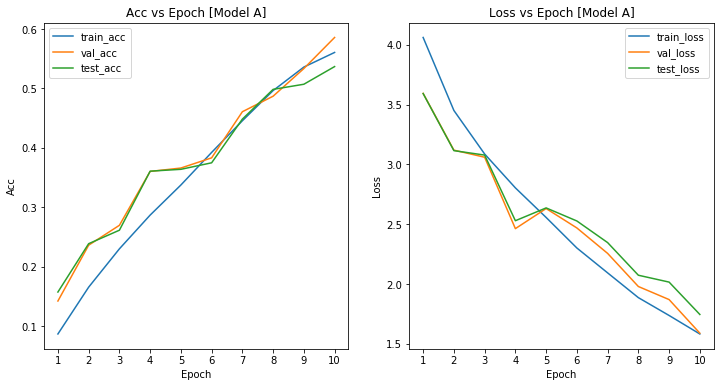

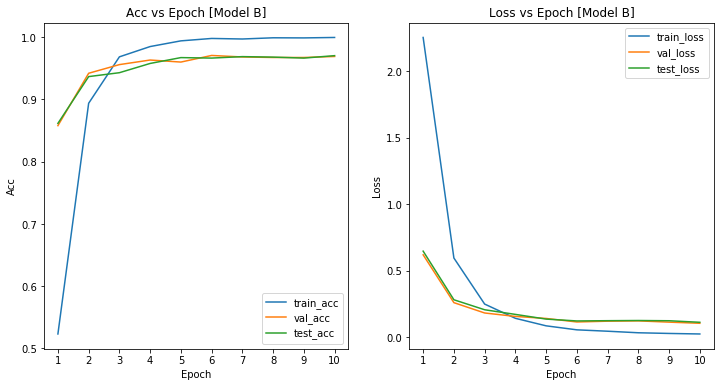

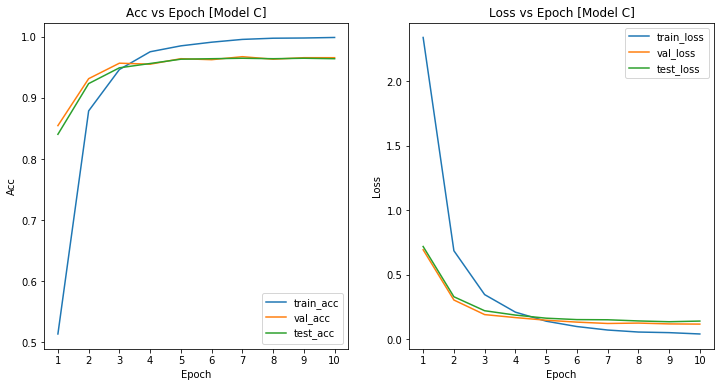

In [7]:
def main():
    # README: Set train, val, test text file paths
    train_txt = './flowers102stuff/trainfile.txt'
    val_txt = './flowers102stuff/valfile.txt'
    test_txt = './flowers102stuff/testfile.txt'
    
    # README: Set directory of flowers_data/jpg
    jpg_dir = './flowers102stuff/102flowers/flowers_data/jpg'
    
    # Set input image size
    input_size = 224 
    
    # Create train, val, test dataloaders
    dataloaders = create_dataloaders(train_txt, val_txt, test_txt, jpg_dir, input_size)   
    
    # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "resnet"

    # Number of classes in the dataset
    num_classes = 102

    # Batch size for training (change depending on how much memory you have)
    batch_size = 128

    # Number of epochs to train for
    num_epochs = 10

    # Flag for feature extracting:
    # When False, we finetune the whole model.
    # When True, we only update layers selected
    feature_extract = None
    
    # Flag for loading pretrained weights
    use_pretrained = None
    
    models = ['A', 'B', 'C']
    graph_data_dict = defaultdict(list)
    
    for model in models:      
        
        print('-' * 10)
        print("Model {}".format(model))
        print('-' * 10)
        
        # Model A: all layers trained, no pretrain weights loaded
        if model == 'A':
            feature_extract=False
            use_pretrained=False
            print('1. No pretrained weights loaded.')
            print('2. Training all layers.')
        
        # Model B: all layers trained, pretrain weights loaded
        if model == 'B':
            feature_extract=False
            use_pretrained=True  
            print('1. Pretrained weights loaded.')
            print('2. Training all layers.')
            
        # Model C: last two layers trained, pretrain weights loaded
        if model == 'C':
            feature_extract=True
            use_pretrained=True
            print('1. Pretrained weights loaded.')
            print('2. Training only last two layers.')
            
        model_ft, input_size = initialize_model(model_name,
                                                num_classes,
                                                feature_extract,
                                                use_pretrained)

        # Print model summary
#         print(summary(model_ft,(3,224,224)))

        # Send the model to GPU
        model_ft = model_ft.to(device)
        
        params_to_update = set_trainable_params(model_ft, feature_extract)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()

        # Train and evaluate
        model_ft, graph_data = train_model(model_ft,
                                           dataloaders,
                                           criterion,
                                           optimizer_ft,
                                           num_epochs=num_epochs,
                                           is_inception=(model_name=="inception"))
        graph_data_dict[model] = graph_data
    
    for model in models:
        plot_graphs(num_epochs, graph_data_dict[model], model)
        
if __name__== "__main__":
  main()